In [34]:
# Import necessary libraries
import pandas as pd
import requests
import json
import influxdb_client
from influxdb import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
#AUTOMATION AREA
# 1) Get company tickers to format URL string
# 2) Format string as such: "https://financialmodelingprep.com/api/v3/income-statement/" + companyName + "?datatype=csv&apikey=" + API_KEY

In [43]:
# Retrieve local API key from file (---this file is not to be pushed to GitHub for security reasons ---)
keyFile="/home/wintergreen/Projects/fskeyfile.txt"
with open(keyFile) as f:
    key = str(f.readline().replace("\n",""))
API_KEY = key

In [68]:
TICKER_TARGET = "AMZN"

In [69]:
URL = "https://financialmodelingprep.com/api/v3/income-statement/" + TICKER_TARGET + "?limit=120&apikey=" + API_KEY

In [70]:
# Make request for data
r = requests.get(URL)

In [71]:
r = r.json()

In [72]:
# Prepare the data
#print(pd.DataFrame.from_dict(r))
data = ((pd.DataFrame.from_dict(r)).sort_values(by=['fillingDate'])).reset_index()

# Combine SellingAndMarketing and generalAndAdministrative into one SGA Cost
data['SellingGeneralAdministrative'] = data.apply(lambda row: row.generalAndAdministrativeExpenses + (row.sellingAndMarketingExpenses), axis=1)

data['SGA_%_GP'] = data.apply(lambda row: row.SellingGeneralAdministrative / (row.grossProfit)*100, axis=1)
data['RD_%_GP'] = data.apply(lambda row: row.researchAndDevelopmentExpenses / (row.grossProfit)*100, axis=1)


# Gather metrics needed for linear time-series graphs
revGrossNet=data[['fillingDate','revenue','grossProfit','netIncome']]

SGA_RD_GP = data[['fillingDate','SGA_%_GP','RD_%_GP']]

AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


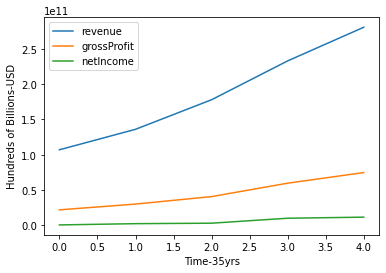

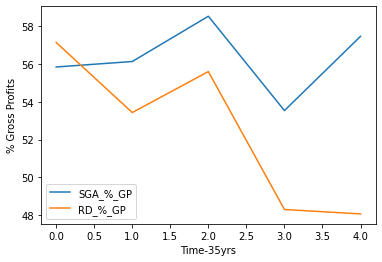

In [73]:
# Plot the data
#plt.figure()
rgnPlot = revGrossNet.plot()
rgnPlot.set_ylabel('Hundreds of Billions-USD')
rgnPlot.set_xlabel('Time-35yrs')

sgardPlot = SGA_RD_GP.plot()
sgardPlot.set_ylabel('% Gross Profits')
sgardPlot.set_xlabel('Time-35yrs')

print(rgnPlot, sgardPlot)